Peyton Wong  

# Plant Disease Detection using MobileNetV2 - Source Notebook

**Dataset Source**: Plant Disease Detection - https://www.kaggle.com/datasets/karagwaanntreasure/plant-disease-detection/data

**License**: MIT

This notebook will explore the "Plant Disease Detection" dataset using transfer learning in MobileNetV2 to classify disease/infestation in plant leaves.

Crops such as apples, corn, bell peppers, potatoes and tomatoes are of the following plant leaves that have been detected for disease and infestation. The dataset holds approximately 35700 images, each folder can be classified as its own class (e.g: Apple__apple_scab, Potato__healthy, etc.). The dataset holds a total of 23 class labels, each will need to be identified in the code in order for the model to classify the image.

Can we create a model that accurately identifies disease or infestation by using plant leaf images? My goal is to hit at least 90% accuracy on the test data.

# Data Loading / Wrangling / Pre-Processing  

This code will demonstrate my data loading, wrangling and pre-processing steps.

In [ ]:
# --- Load required packages ---
import os
import random
import numpy as np
import pandas as pd
import shutil
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

In [ ]:
# --- Download dataset directly from Kaggle API ---
path = kagglehub.dataset_download("karagwaanntreasure/plant-disease-detection")
print("Path to dataset files:", path)

100%|██████████| 534M/534M [00:14<00:00, 38.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karagwaanntreasure/plant-disease-detection/versions/1


In [ ]:
# --- Identify Reproducibility ---
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# --- Data Directory ---
# The directory switches between two different paths, use the one that the code declares

# --- The directory not being used needs to be placed in a comment! ---
data_dir = "/root/.cache/kagglehub/datasets/karagwaanntreasure/plant-disease-detection/versions/1/Dataset"

# data_dir = "/kaggle/input/plant-disease-detection/Dataset/"

In [ ]:
# --------------------------------
# --- Confirm classes + counts ---
# --------------------------------

all_image_paths = []
all_labels = []

for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        files = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        all_image_paths.extend(files)
        all_labels.extend([class_name] * len(files))

df = pd.DataFrame({"filepath": all_image_paths, "label": all_labels})

print("Number of classes:", df['label'].nunique())
print("Classes:", df['label'].unique())
print("Counts per class:")
print(df['label'].value_counts())

Number of classes: 23
Classes: ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Tomato_Bacterial_spot' 'Tomato_Early_blight'
 'Tomato_Late_blight' 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']
Counts per class:
label
Tomato__Tomato_YellowLeaf__Curl_Virus                 3209
Tomato_Bacterial_spot                                 2127
Apple___Apple_scab                                    2016
Apple___healthy                                       2008
Apple___Black_rot                                     1987
Tomato_Late_bli

In [ ]:
# -----------------------------------------------------------
# --- Train/Val/Test split (70/15/15 with stratification) ---
# -----------------------------------------------------------
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,  # 30% for val+test
    stratify=df['label'],
    random_state=seed
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # split 30% into half = 15/15
    stratify=temp_df['label'],
    random_state=seed
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 25008, Val: 5359, Test: 5359


In [ ]:
# ------------------------------------
# --- Check for missing file paths ---
# ------------------------------------

print("Missing file paths in train:", train_df['filepath'].isnull().sum())
print("Missing file paths in val:", val_df['filepath'].isnull().sum())
print("Missing file paths in test:", test_df['filepath'].isnull().sum())

# --- Check for missing files in data splits ---

print("Nonexistent files in train:", sum([not os.path.exists(p) for p in train_df['filepath']]))
print("Nonexistent files in val:", sum([not os.path.exists(p) for p in val_df['filepath']]))
print("Nonexistent files in test:", sum([not os.path.exists(p) for p in test_df['filepath']]))

Missing file paths in train: 0
Missing file paths in val: 0
Missing file paths in test: 0
Nonexistent files in train: 0
Nonexistent files in val: 0
Nonexistent files in test: 0


In [ ]:
# ---------------------------------
# ------- Data Augmentation -------
# ---------------------------------
normalization_layer = tf.keras.layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [ ]:
# ------------------------------------------------
# --- Create a consistent global class mapping ---
# ------------------------------------------------

# Prevents mismatched label encodings across train/val/test
global_class_names = sorted(df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(global_class_names)}

In [ ]:
# ----------------------------------------------------------------
# --- Dataset Builder Function / Data Augmentation on Training ---
# ----------------------------------------------------------------

# Batch size is 32 with 224x224 pixel images
def make_dataset(df, training=False, batch_size=32, img_size=(224,224)):
    filepaths = df["filepath"].values
    labels = df["label"].map(class_to_idx).values  # for consistent encoding

    # --- Filter out missing/null files ---
    valid_pairs = [(p, l) for p, l in zip(filepaths, labels) if p and os.path.exists(p)]
    if not valid_pairs:
        raise ValueError("No valid image files found!")

    filepaths, labels = zip(*valid_pairs)

    # Create Dataset from arrays
    ds = tf.data.Dataset.from_tensor_slices((list(filepaths), list(labels)))

    # ------- Preprocessing pipeline -------
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        return img, label

    # Use ignore_errors() to filter corrupt files
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.apply(tf.data.experimental.ignore_errors())  # skips corrupt files safely

    # Data augmentation (training only)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    # Normalize + one-hot encode
    ds = ds.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, len(global_class_names))),
                num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle only on training
    if training:
        ds = ds.shuffle(buffer_size=1000, seed=42)

    # Batch + prefetch
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# -----------------------
# --- Create datasets ---
# -----------------------

train_ds = make_dataset(train_df, training=True)
val_ds = make_dataset(val_df)
test_ds = make_dataset(test_df)

print("Classes:", global_class_names)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# Build / Compile / Train on MobileNetV2 with Fine-Tuning

- Transfer learning in Keras (MobileNetV2)
- Fine-tuned with freezing only the early-layers of backbone, add a small classification head, train 10 epochs with light augmentation, best model checkpoint and early stopping.
- Using mixed precision for recent GPU; keeps input size at 224×224 to move quickly.
- Augmentations: horizontal flip, small rotation/zoom, and mild color/contrast jitter

In [ ]:
# --- Double check download on required packages ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [ ]:
# --- Enable mixed precision if GPU supports it ---

# (Speeds up training on modern GPUs like RTX/A100)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
# -------------------------------------------------
# --- Build MobileNetV2 Transfer Learning Model ---
# -------------------------------------------------

# Implement Early Stop
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Implement Model Checkpoint
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# --- Define MobileNetV2 model ---
def build_mobilenet(num_classes, input_shape=(224, 224, 3)):
    # Using MobileNetV2 backbone pretrained on ImageNet
    base_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg"
    )

    # Unfreeze backbone
    base_model.trainable = True

    # Freeze the very early layers
    fine_tune_at = 100  # MobileNetV2 has 155 layers total
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Small classification head
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)  # regularization
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    # (dtype="float32" ensures numerical stability w/ mixed precision)

    model = models.Model(inputs, outputs)

    # ------- Compile the Model -------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
# ---------------------------------
# --- Build and summarize model ---
# ---------------------------------
model = build_mobilenet(num_classes=len(global_class_names))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │        29,463 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,287,447 (8.73 MB)

 Trainable params: 1,890,903 (7.21 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
# ---------------------------------
# --- Train model for 10 epochs ---
# ---------------------------------

# With GPU training time takes 45-50 minutes
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
    782/Unknown 406s 407ms/step - accuracy: 0.3323 - loss: 2.4073

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.95024, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 436s 445ms/step - accuracy: 0.3326 - loss: 2.4064 - val_accuracy: 0.7343 - val_loss: 0.9502
Epoch 2/10
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7947 - loss: 0.7360
Epoch 2: val_loss improved from 0.95024 to 0.48694, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 299s 369ms/step - accuracy: 0.7948 - loss: 0.7357 - val_accuracy: 0.8563 - val_loss: 0.4869
Epoch 3/10
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8726 - loss: 0.4206
Epoch 3: val_loss improved from 0.48694 to 0.31748, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 299s 340ms/step - accuracy: 0.8727 - loss: 0.4205 - val_accuracy: 0.9004 - val_loss: 0.3175
Epoch 4/10
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9077 - loss: 0.3026
Epoch 4: val_loss improved from 0.31748 to 0.25858, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 275s 33

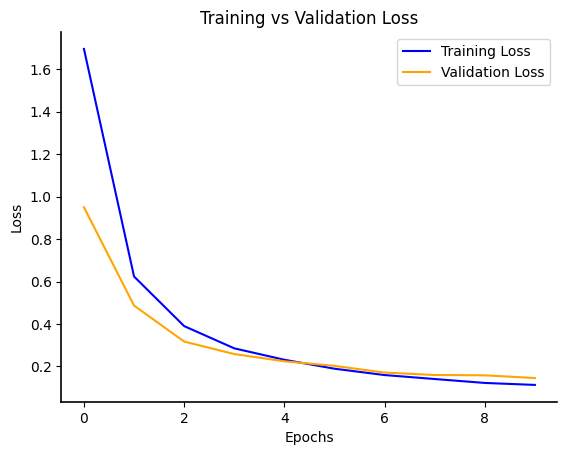

In [ ]:
# -----------------------------------------
# --- Plot Training and Validation Loss ---
# -----------------------------------------

plt.plot(history.history["loss"], color='blue', label='Training Loss')
plt.plot(history.history["val_loss"], color='orange', label='Validation Loss')

# Labels and titles
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Remove top and right spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Make axes thicker
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Save to PNG
plt.savefig("loss_plot_mobile_original.png", dpi=300, bbox_inches='tight')
plt.show()

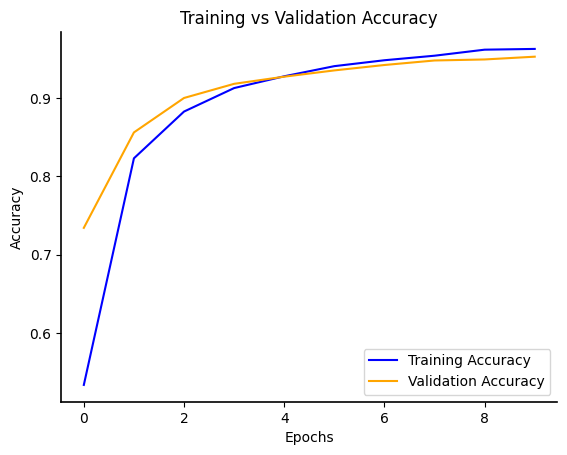

In [ ]:
# ---------------------------------------------
# --- Plot Training Vs. Validation Accuracy ---
# ---------------------------------------------

plt.plot(history.history["accuracy"], color = 'blue', label='Training Accuracy')
plt.plot(history.history["val_accuracy"], color = 'orange', label='Validation Accuracy')

# Add labels and title
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')

# Remove top and right spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Make axes thicker
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Save to PNG
plt.savefig("accuracy_plot_mobile_original.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# -----------------------------------------------------
# --- Overview of Minimum Loss and Maximum Accuracy ---
# -----------------------------------------------------

print('Minimum Training Loss:', min(history.history["loss"]))
print('Minimum Validation Loss:', min(history.history["val_loss"]))
print('Maximum Training Accuracy:', max(history.history["accuracy"]))
print('Maximum Validation Accuracy:', max(history.history["val_accuracy"]))

Minimum Training Loss: 0.11322197318077087
Minimum Validation Loss: 0.1456678807735443
Maximum Training Accuracy: 0.9630903601646423
Maximum Validation Accuracy: 0.9531629085540771


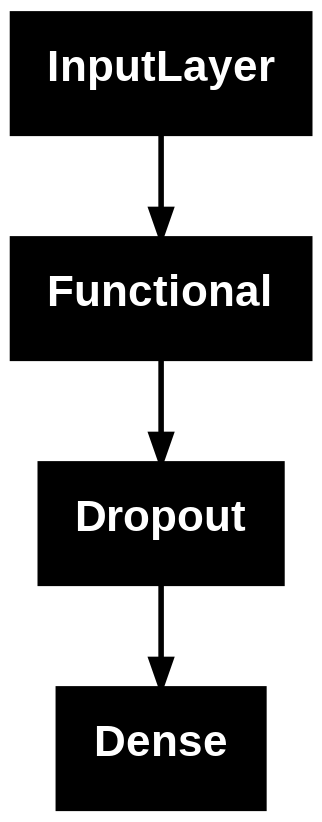

In [ ]:
# ----------------------
# --- Plot the Model ---
# ----------------------
plot_model(model, show_shapes = False)

# Evaluation on Test Data - Classification Report - Confusion Matrix

In [ ]:
# Import required packages (if not already)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# ----------------------------
# --- Evaluate on test set ---
# ----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9508 - loss: 0.1448
Test Accuracy: 0.9524


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# -------------------------------------------
# --- Collect predictions and true labels ---
# -------------------------------------------

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))   # one-hot → class index
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
# -----------------------------
# --- Classification Report ---
# -----------------------------

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=global_class_names))


Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.99      0.99       302
                                 Apple___Black_rot       0.99      1.00      0.99       298
                          Apple___Cedar_apple_rust       1.00      0.98      0.99       264
                                   Apple___healthy       0.99      0.99      0.99       301
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.94      0.94       246
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       286
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.96      0.95       286
                            Corn_(maize)___healthy       1.00      1.00      1.00       279
                     Pepper__bell___Bacterial_spot       0.99      1.00      0.99       149
                            Pepper__bell___healthy     

In [ ]:
# --------------------------------
# --- Confusion Matrix Helpers ---
# --------------------------------

def plot_cm(cm, class_names, title="Confusion Matrix", normalize=None, annotate_threshold=None, figsize=(12,10)):
    """
    normalize: None, 'true' (row-normalize), or 'pred' (column-normalize)
    annotate_threshold: if set, annotate cells whose value >= threshold (after normalization)
    """
    cm_plot = cm.astype(float)
    if normalize == 'true':
        cm_plot = cm_plot / cm_plot.sum(axis=1, keepdims=True)
    elif normalize == 'pred':
        cm_plot = cm_plot / cm_plot.sum(axis=0, keepdims=True)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm_plot, cmap="Blues", cbar=True,
                     xticklabels=class_names, yticklabels=class_names,
                     square=False)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # Optional annotations
    if annotate_threshold is not None:
        n = cm_plot.shape[0]
        for i in range(n):
            for j in range(n):
                val = cm_plot[i, j]
                if np.isnan(val):
                    continue
                if val >= annotate_threshold:
                    txt = f"{val:.2f}" if normalize else f"{int(val)}"
                    ax.text(j+0.5, i+0.5, txt, ha="center", va="center", fontsize=8, color="black")

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Anytime savefig executes on confusion matrices below, it will save here
    plt.savefig("confusion_matrix_recent_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

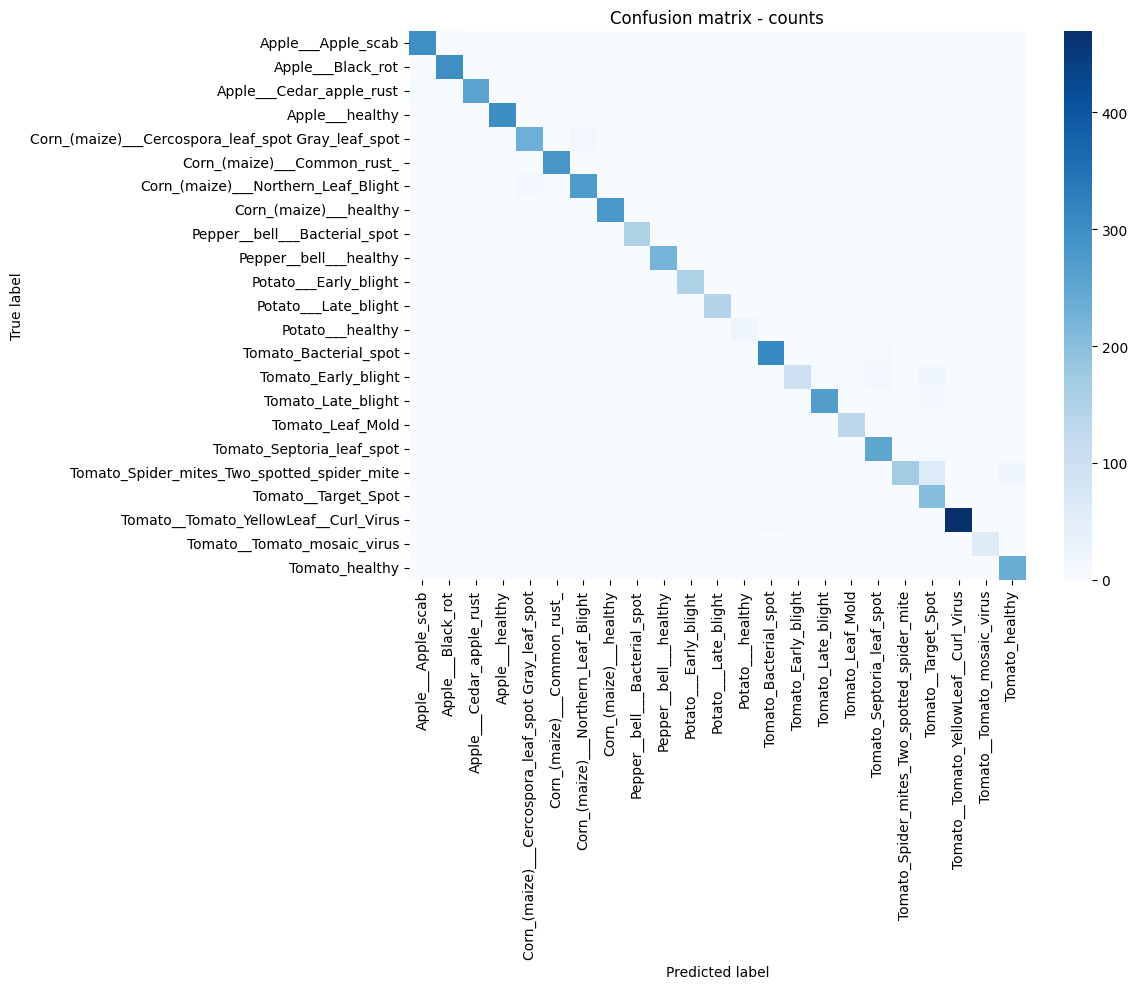

<Figure size 640x480 with 0 Axes>

In [ ]:
# ----------------------------------------
# --- Build Raw Count Confusion Matrix ---
# ----------------------------------------

# Define confusion matrix as cm
cm = confusion_matrix(y_true, y_pred, labels=range(len(global_class_names)))

plot_cm(cm, global_class_names, title="Confusion matrix - counts", normalize=None)
plt.savefig("cm_counts.png", dpi=300, bbox_inches='tight')

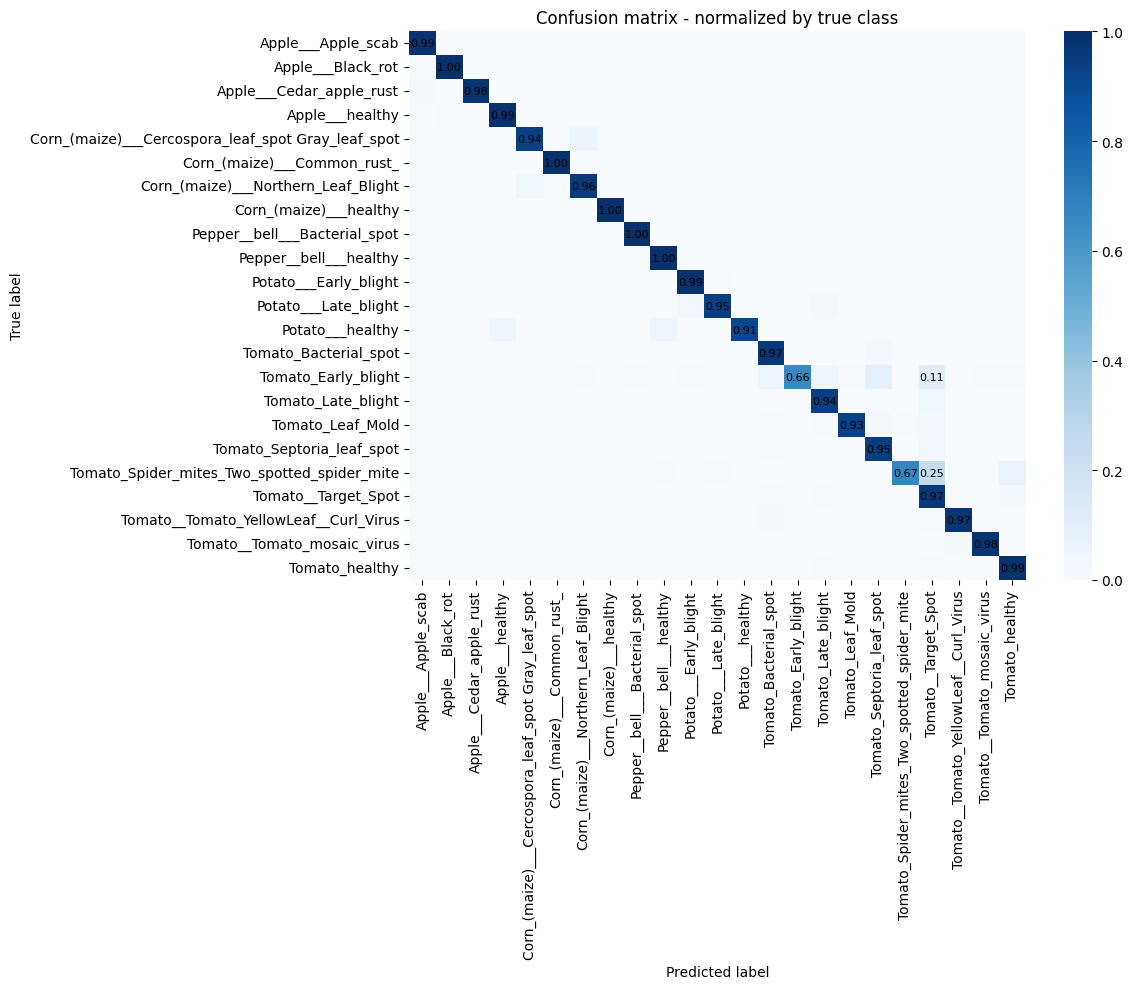

<Figure size 640x480 with 0 Axes>

In [ ]:
# --------------------------------------------------------------
# --- Build Confusion Matrix with Row-normalized percentages ---
# --------------------------------------------------------------

plot_cm(cm, global_class_names, title="Confusion matrix - normalized by true class", normalize='true', annotate_threshold=0.10)
plt.savefig("cm_normalized.png", dpi=300, bbox_inches='tight')

/tmp/ipython-input-3051988400.py:12: RuntimeWarning: invalid value encountered in divide
  cm_plot = cm_plot / cm_plot.sum(axis=1, keepdims=True)


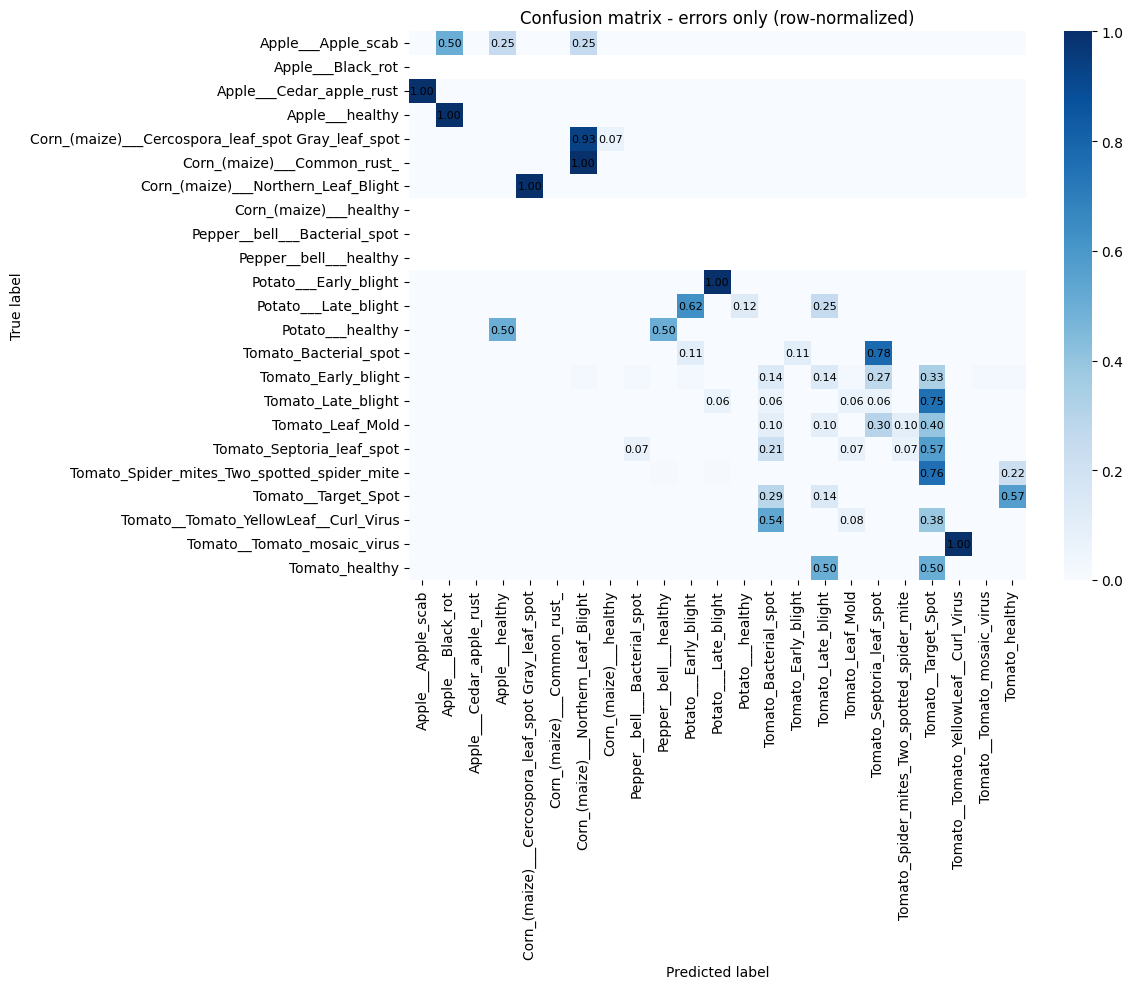

<Figure size 640x480 with 0 Axes>

In [ ]:
# ----------------------------------------------------------------------
# --- Build Confusion Matrix with Error-only view (diagonal zeroed) ---
# -------------------- (With Row Normalization) ------------------------
# ----------------------------------------------------------------------

cm_err = cm.copy()
np.fill_diagonal(cm_err, 0)
plot_cm(cm_err, global_class_names, title="Confusion matrix - errors only (row-normalized)", normalize='true', annotate_threshold=0.05)
plt.savefig("cm_errors.png", dpi=300, bbox_inches='tight')

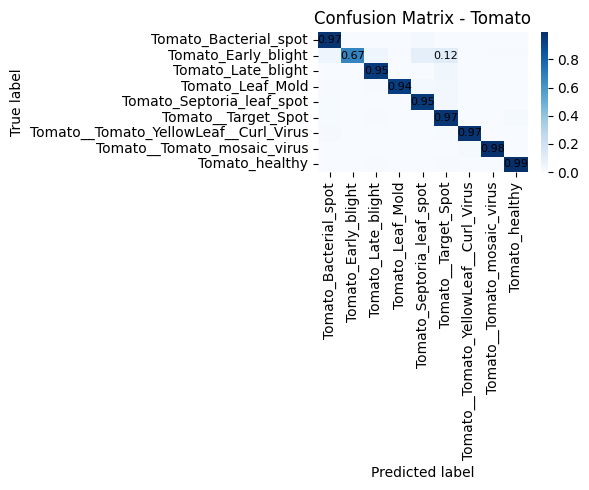

<Figure size 640x480 with 0 Axes>

In [ ]:
# ------------------------------------------------
# --- Closer Look on Confusion Matrix - Tomato ---
# ------------------------------------------------

def plot_cm_subset(full_cm, class_names, keep):
    """
    keep: list of class names to zoom in on (order preserved)
    """
    idx = [class_names.index(c) for c in keep]
    sub_cm = full_cm[np.ix_(idx, idx)]
    plot_cm(sub_cm, keep, title="Confusion Matrix - Tomato", normalize='true', annotate_threshold=0.10, figsize=(6,5))


def top_confusions(cm, class_names, k=10):
    """Return the top off-diagonal confusions as (true, pred, count)."""
    cm_err = cm.copy()
    np.fill_diagonal(cm_err, 0)
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm_err[i, j] > 0:
                pairs.append((class_names[i], class_names[j], int(cm_err[i, j])))
    return sorted(pairs, key=lambda x: x[2], reverse=True)[:k]

# Zoom into a few tomato diseases
zoom_classes = [
    "Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight",
    "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot", "Tomato__Target_Spot",
    "Tomato__Tomato_YellowLeaf__Curl_Virus", "Tomato__Tomato_mosaic_virus",
    "Tomato_healthy"
]
plot_cm_subset(cm, global_class_names, zoom_classes)
plt.savefig("cm_subset.png", dpi=300, bbox_inches='tight')

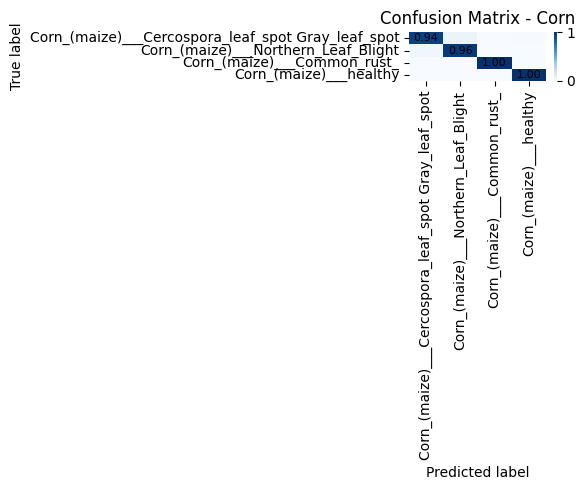

<Figure size 640x480 with 0 Axes>

In [ ]:
# ----------------------------------------------
# --- Closer Look on Confusion Matrix - Corn ---
# ----------------------------------------------

def plot_cm_subset(full_cm, class_names, keep):
    idx = [class_names.index(c) for c in keep]
    sub_cm = full_cm[np.ix_(idx, idx)]
    plot_cm(sub_cm, keep, title='Confusion Matrix - Corn', normalize='true', annotate_threshold=0.10, figsize=(6,5))


def top_confusions(cm, class_names, k=10):
    cm_err = cm.copy()
    np.fill_diagonal(cm_err, 0)
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm_err[i, j] > 0:
                pairs.append((class_names[i], class_names[j], int(cm_err[i, j])))
    return sorted(pairs, key=lambda x: x[2], reverse=True)[:k]

# Zoom into corn categories
zoom_classes = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___Common_rust_", "Corn_(maize)___healthy",
]
plot_cm_subset(cm, global_class_names, zoom_classes)
plt.savefig("cm_subset_2.png", dpi=300, bbox_inches='tight')

In [ ]:
# -------------------------------------------
# Print Top 12 Worst Confusion Pairs by Count
# -------------------------------------------

print("Top confusions:", top_confusions(cm, global_class_names, k=12))

Top confusions: [('Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 62), ('Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_healthy', 18), ('Tomato_Early_blight', 'Tomato__Target_Spot', 17), ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Northern_Leaf_Blight', 14), ('Tomato_Early_blight', 'Tomato_Septoria_leaf_spot', 14), ('Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 12), ('Tomato_Late_blight', 'Tomato__Target_Spot', 12), ('Tomato_Septoria_leaf_spot', 'Tomato__Target_Spot', 8), ('Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 7), ('Tomato_Early_blight', 'Tomato_Bacterial_spot', 7), ('Tomato_Early_blight', 'Tomato_Late_blight', 7), ('Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 7)]


# Model Evaluation - Deeper Dive
- Multiclass ROC Curves / Deep-Dive on Tomato Classes
- Precision/Recall Curves / Deep-Dive on Tomato Classes
- Bar chart on accuracy per class / accuracy per tomato class

In [ ]:
# --- Double Check Required Packages are Imported ---
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import itertools

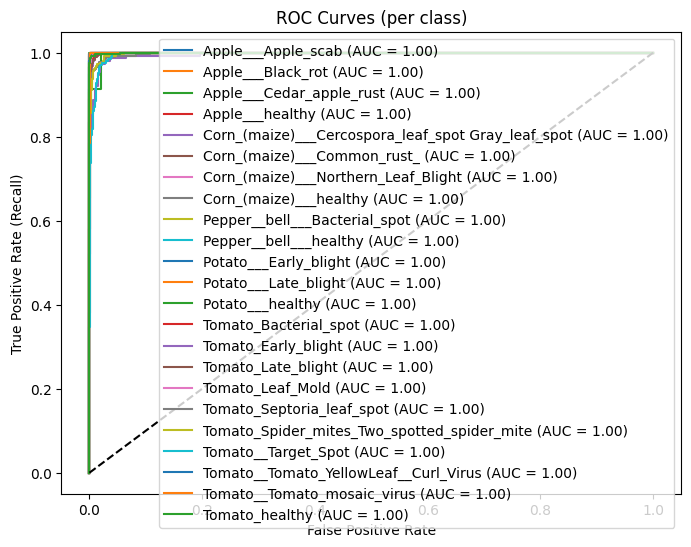

In [ ]:
# --------------------------------------------------
# ---------- ROC CURVES (Multi-class) --------------
# --------------------------------------------------

def plot_multiclass_roc(model, test_ds, class_names):
    y_true = []
    y_score = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_score.extend(preds)

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # One-hot true labels
    y_true_bin = label_binarize(np.argmax(y_true, axis=1), classes=range(len(class_names)))

    plt.figure(figsize=(8,6))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curves (per class)")
    plt.legend()
    plt.savefig('roc_curves_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run ROC
plot_multiclass_roc(model, test_ds, global_class_names)

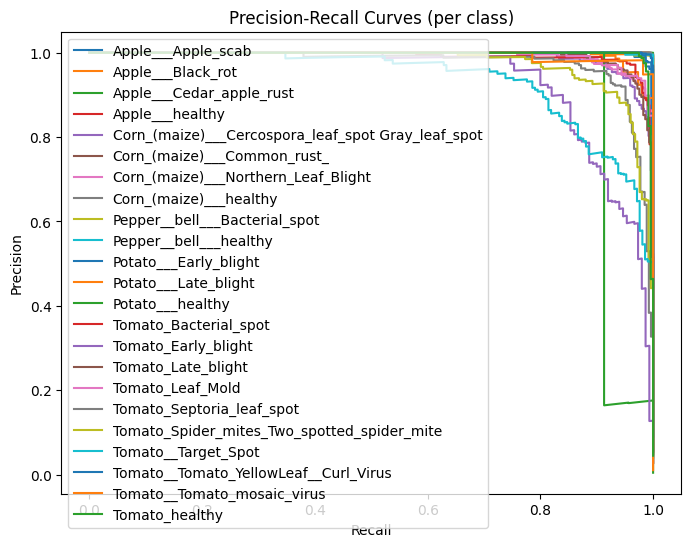

In [ ]:
# --------------------------------------------------
# ----- PRECISION–RECALL CURVES (Multi-class) ------
# --------------------------------------------------

def plot_multiclass_pr(model, test_ds, class_names):
    y_true = []
    y_score = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_score.extend(preds)

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    y_true_bin = label_binarize(np.argmax(y_true, axis=1), classes=range(len(class_names)))

    plt.figure(figsize=(8,6))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f"{class_name}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (per class)")
    plt.legend()

    plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# ---- Run Plot ----
plot_multiclass_pr(model, test_ds, global_class_names)

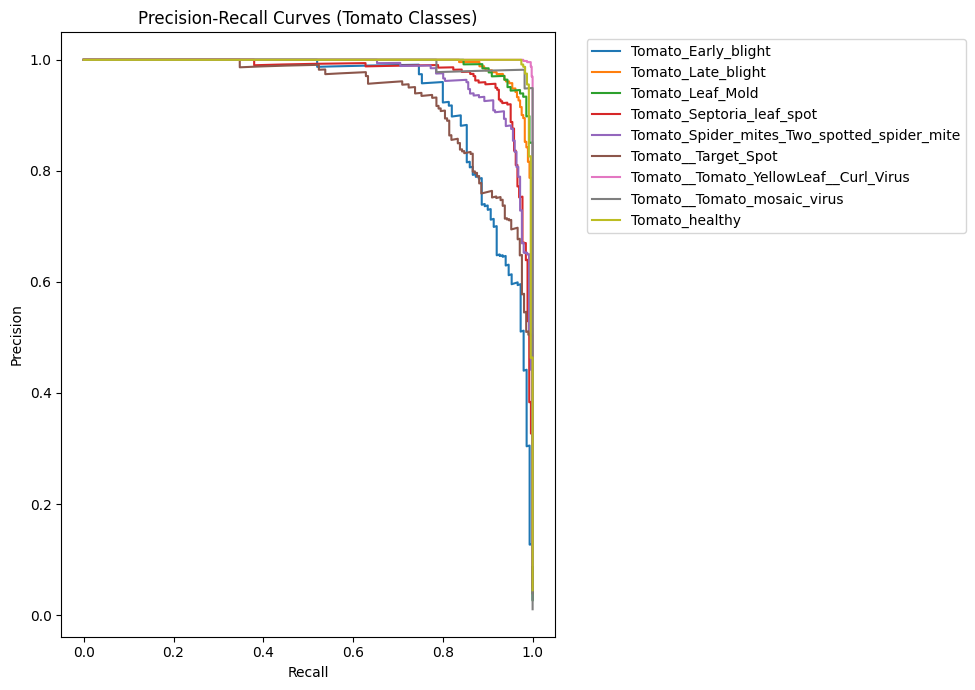

In [ ]:
# ---------------------------------------------------------
# ----- PRECISION–RECALL CURVES (Filtered to Tomato) ------
# ---------------------------------------------------------

def plot_multiclass_pr(model, test_ds, class_names, target_classes=None):
    y_true = []
    y_score = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_score.extend(preds)

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # One-hot binarize labels
    y_true_bin = label_binarize(np.argmax(y_true, axis=1), classes=range(len(class_names)))

    plt.figure(figsize=(10, 7))

    # If no target_classes provided, default to all classes
    if target_classes is None:
        target_classes = class_names

    for class_name in target_classes:
        if class_name not in class_names:
            print(f"Warning: {class_name} not in class_names, skipping.")
            continue

        i = class_names.index(class_name)  # index of this class
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f"{class_name}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Tomato Classes)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    plt.savefig('precision_recall_curves_tomato.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- Plot with only tomato classes ---
tomato_classes = [
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

plot_multiclass_pr(model, test_ds, global_class_names, target_classes=tomato_classes)

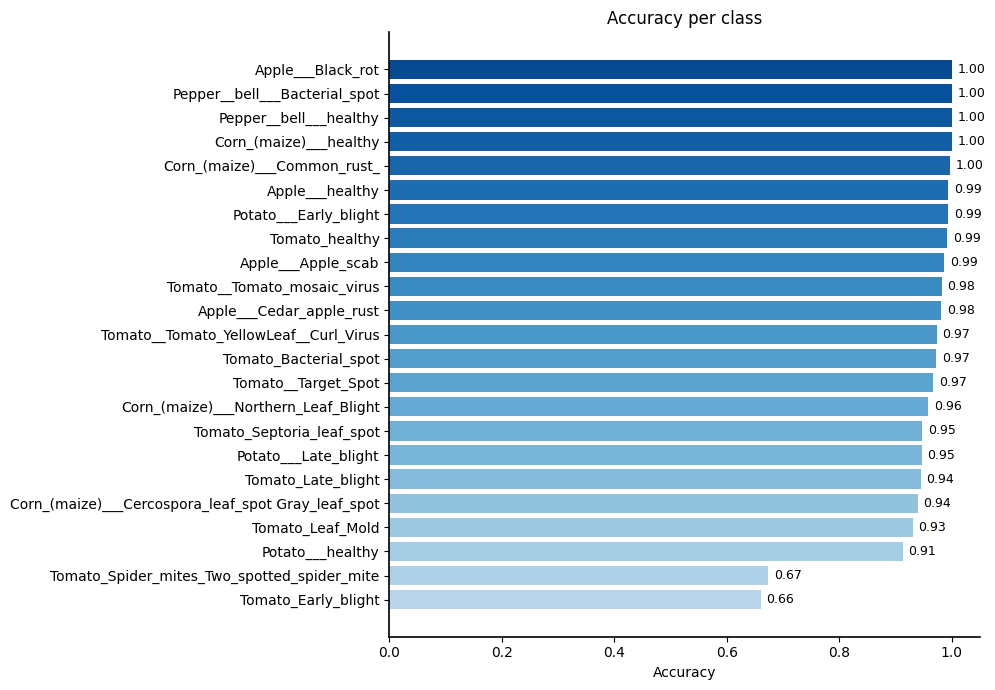

In [ ]:
# --------------------------------------------------
# ---------- PER-CLASS ACCURACY BAR CHART ----------
# --------------------------------------------------

def plot_class_accuracy(model, test_ds, class_names):
    correct = np.zeros(len(class_names))
    total = np.zeros(len(class_names))

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true = np.argmax(labels.numpy(), axis=1)
        y_pred = np.argmax(preds, axis=1)

        for i in range(len(y_true)):
            total[y_true[i]] += 1
            if y_true[i] == y_pred[i]:
                correct[y_true[i]] += 1

    acc = correct / total

    # --- Sort in ascending order ---
    sorted_idx = np.argsort(acc)  # ascending now
    sorted_acc = acc[sorted_idx]
    sorted_names = [class_names[i] for i in sorted_idx]

    # --- Blue gradient (light = low, dark = high) ---
    cmap = plt.cm.Blues
    colors = cmap(np.linspace(0.3, 0.9, len(sorted_names)))  # avoid extremes of white/black

    plt.figure(figsize=(10, 7))
    bars = plt.barh(sorted_names, sorted_acc, color=colors)

    plt.xlabel("Accuracy")
    plt.title("Accuracy per class")
    plt.xlim(0, 1.05)         # Accuracy is between 0 and 1

    # Style: clean look
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

    # Annotate bars with values
    for bar, val in zip(bars, sorted_acc):
        plt.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{val:.2f}", va="center", fontsize=9)

    plt.tight_layout()
    plt.savefig('accuracy_per_class.png', dpi=300, bbox_inches='tight')
    plt.show()

# ---- Per-class accuracy plot ----
plot_class_accuracy(model, test_ds, global_class_names)

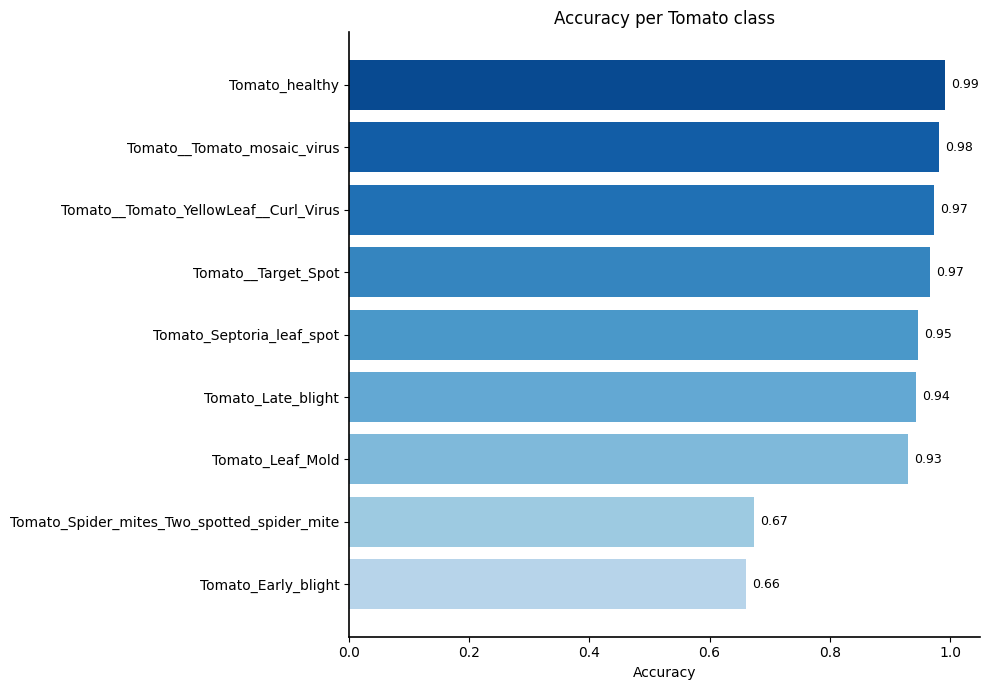

In [ ]:
# -------------------------------------------------------------------
# ---------- PER-CLASS ACCURACY BAR CHART (Tomato Classes) ----------
# -------------------------------------------------------------------

def plot_class_accuracy(model, test_ds, class_names):
    correct = np.zeros(len(class_names))
    total = np.zeros(len(class_names))

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true = np.argmax(labels.numpy(), axis=1)
        y_pred = np.argmax(preds, axis=1)

        for i in range(len(y_true)):
            total[y_true[i]] += 1
            if y_true[i] == y_pred[i]:
                correct[y_true[i]] += 1

    acc = correct / total

    # --- Select only tomato classes ---
    tomato_classes = [
        'Tomato_Early_blight',
        'Tomato_Late_blight',
        'Tomato_Leaf_Mold',
        'Tomato_Septoria_leaf_spot',
        'Tomato_Spider_mites_Two_spotted_spider_mite',
        'Tomato__Target_Spot',
        'Tomato__Tomato_YellowLeaf__Curl_Virus',
        'Tomato__Tomato_mosaic_virus',
        'Tomato_healthy'
    ]

    tomato_idx = [class_names.index(c) for c in tomato_classes if c in class_names]
    tomato_acc = acc[tomato_idx]
    tomato_names = [class_names[i] for i in tomato_idx]

    # --- Sort in ascending order ---
    sorted_idx = np.argsort(tomato_acc)
    sorted_acc = tomato_acc[sorted_idx]
    sorted_names = [tomato_names[i] for i in sorted_idx]

    # --- Blue gradient (light = low, dark = high) ---
    cmap = plt.cm.Blues
    colors = cmap(np.linspace(0.3, 0.9, len(sorted_names)))

    plt.figure(figsize=(10, 7))
    bars = plt.barh(sorted_names, sorted_acc, color=colors)

    plt.xlabel("Accuracy")
    plt.title("Accuracy per Tomato class")
    plt.xlim(0, 1.05)

    # Style: clean look
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

    # Annotate bars with values
    for bar, val in zip(bars, sorted_acc):
        plt.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{val:.2f}", va="center", fontsize=9)

    plt.tight_layout()
    plt.savefig('accuracy_per_tomato_classes.png', dpi=300, bbox_inches='tight')
    plt.show()

# ---- Per-class accuracy plot (tomato only) ----
plot_class_accuracy(model, test_ds, global_class_names)

# Saliency Map  
Salieny Map based on extracting an image from test dataset, comparison of true and predicted labels, followed by saliency map to conclude that model is analyzing lesions on leaf

In [ ]:
# --------------------------------------------------
# ------ SALIENCY MAP (Gradients wrt Input) --------
# --------------------------------------------------

def compute_saliency_map(model, image, class_index=None):
    """
    image: np.array shape (H,W,3) in [0,1]
    class_index: int (if None, use predicted class)
    """
    img_tensor = tf.convert_to_tensor(image[np.newaxis, ...])  # add batch

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, img_tensor)[0]  # (H,W,3)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()  # take max channel
    saliency = (saliency - saliency.min()) / (saliency.max() + 1e-8)  # normalize
    return saliency


def plot_saliency(model, img, class_names, true_idx):
    preds = model.predict(img[np.newaxis,...])
    pred_idx = int(np.argmax(preds[0]))
    saliency = compute_saliency_map(model, img, class_index=pred_idx)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(f"Original\nTrue: {class_names[true_idx]}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(saliency, cmap="hot")
    plt.title("Saliency Map")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.imshow(saliency, cmap="hot", alpha=0.5)
    plt.title(f"Overlay\nPred: {class_names[pred_idx]}")
    plt.axis("off")
    plt.savefig('saliency_map.png', dpi=300, bbox_inches='tight')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


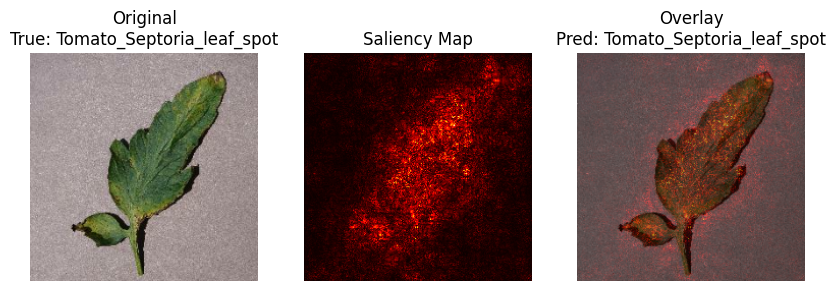

In [ ]:
# Run 1: Saliency on one test image
images, labels = next(iter(test_ds))
img01 = images[0].numpy()
true_idx = int(np.argmax(labels[0].numpy()))
plot_saliency(model, img01, global_class_names, true_idx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


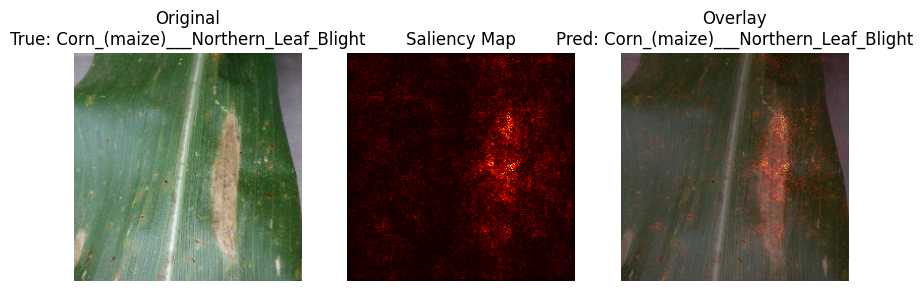

In [ ]:
# Run 2: Saliency on one test image
images, labels = next(iter(test_ds))
img01 = images[3].numpy()
true_idx = int(np.argmax(labels[3].numpy()))
plot_saliency(model, img01, global_class_names, true_idx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


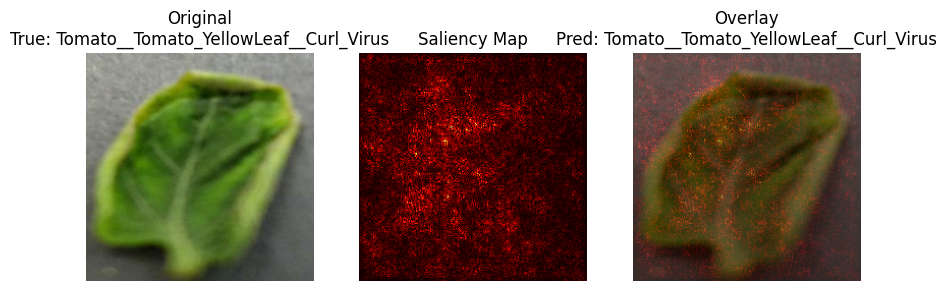

In [ ]:
# Run 3: Saliency on one test image
images, labels = next(iter(test_ds))
img01 = images[13].numpy()
true_idx = int(np.argmax(labels[13].numpy()))
plot_saliency(model, img01, global_class_names, true_idx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


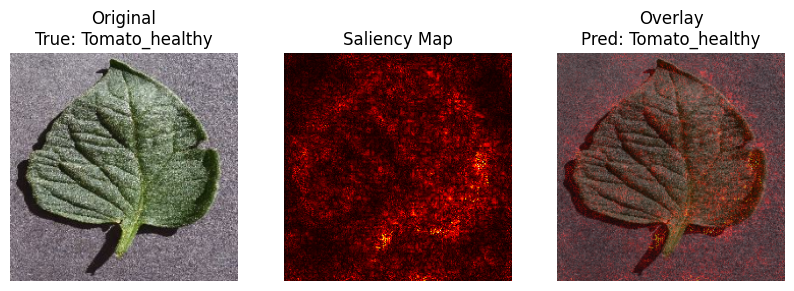

In [ ]:
# Run 4: Saliency on one test image
images, labels = next(iter(test_ds))
img01 = images[25].numpy()
true_idx = int(np.argmax(labels[25].numpy()))
plot_saliency(model, img01, global_class_names, true_idx)

# Self Reflection  

Building a CNN has posed as my most ambitious project by far. Having only a basic understanding to building, compiling and training a CNN model, more extensive self-research had to be done in order for me to understand the ideas of transfer learning.  

ChatGPT helped me to implement transfer learning using MobileNetV2, supporting me in building the classification head with dropout and softmax output layer for multi-class classification. In creating my evaluation visuals, ChatGPT helped suggest what I can try as alternatives to my GRAD CAM attempt (which unfortunetly didn't work, likely because of how we created the preprocessing pipeline). Alternatives, such as multi-class ROC curves, plotting accuracy per class and saliency maps helped me to better picture my model's evaluation.